In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', 50)
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.grid'] = True

print("Ready ✅")

Ready ✅


In [3]:
# 2. Load dataset
df_raw = pd.read_csv("data.csv", encoding="ISO-8859-1")
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
# ========== Step 3. Data Cleaning ==========
df = df_raw.copy()

In [5]:
# Basic dtype fixes
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [6]:
# Buat total price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [7]:
# Simpan baris returns (Quantity < 0) untuk analisis terpisah
returns_df = df[df['Quantity'] < 0].copy()

In [8]:
# Filter transaksi valid untuk analisis penjualan
sales_df = df[
    (df['Quantity'] > 0) &
    (df['UnitPrice'] > 0) &
    (~df['CustomerID'].isna())
].copy()

In [9]:
# Hilangkan duplikat invoice-item jika ada
sales_df.drop_duplicates(subset=['InvoiceNo', 'StockCode', 'Quantity', 'UnitPrice'], inplace=True)
sales_df['CustomerID'] = sales_df['CustomerID'].astype(str)

In [10]:
# Feature engineering tanggal
sales_df['InvoiceDateOnly'] = sales_df['InvoiceDate'].dt.date
sales_df['InvoiceMonth']    = sales_df['InvoiceDate'].dt.to_period('M')
sales_df['Year']            = sales_df['InvoiceDate'].dt.year
sales_df['Month']           = sales_df['InvoiceDate'].dt.month
sales_df['Hour']            = sales_df['InvoiceDate'].dt.hour
sales_df['DayOfWeek']       = sales_df['InvoiceDate'].dt.dayofweek  # 0=Mon

In [11]:
# Ringkasan data
date_min, date_max = sales_df['InvoiceDate'].min(), sales_df['InvoiceDate'].max()
n_orders  = sales_df['InvoiceNo'].nunique()
n_customers = sales_df['CustomerID'].nunique()
n_products  = sales_df['StockCode'].nunique()
n_countries = sales_df['Country'].nunique()
total_revenue = sales_df['TotalPrice'].sum()

print(f"Range tanggal: {date_min.date()} -> {date_max.date()}")
print(f"Orders: {n_orders:,} | Customers: {n_customers:,} | Products: {n_products:,} | Countries: {n_countries}")
print(f"Total Revenue: £{total_revenue:,.2f}")

Range tanggal: 2010-12-01 -> 2011-12-09
Orders: 18,532 | Customers: 4,338 | Products: 3,665 | Countries: 37
Total Revenue: £8,886,653.14


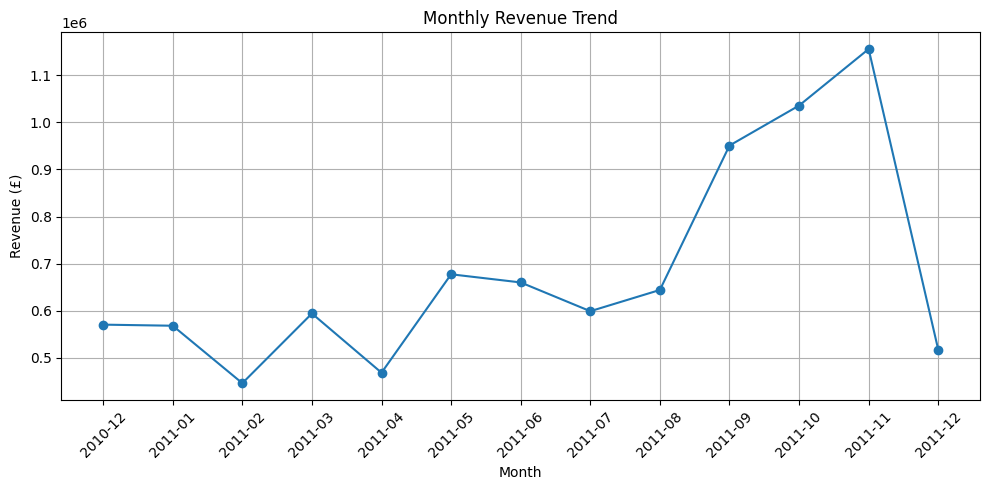

In [12]:
# ========== Step 4. Exploratory Data Analysis ==========

# ---- 4.1 Tren Penjualan Bulanan ----
monthly_rev = sales_df.groupby('InvoiceMonth')['TotalPrice'].sum().sort_index()
plt.figure()
monthly_rev.index = monthly_rev.index.astype(str)
plt.plot(monthly_rev.index, monthly_rev.values, marker='o')
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue (£)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

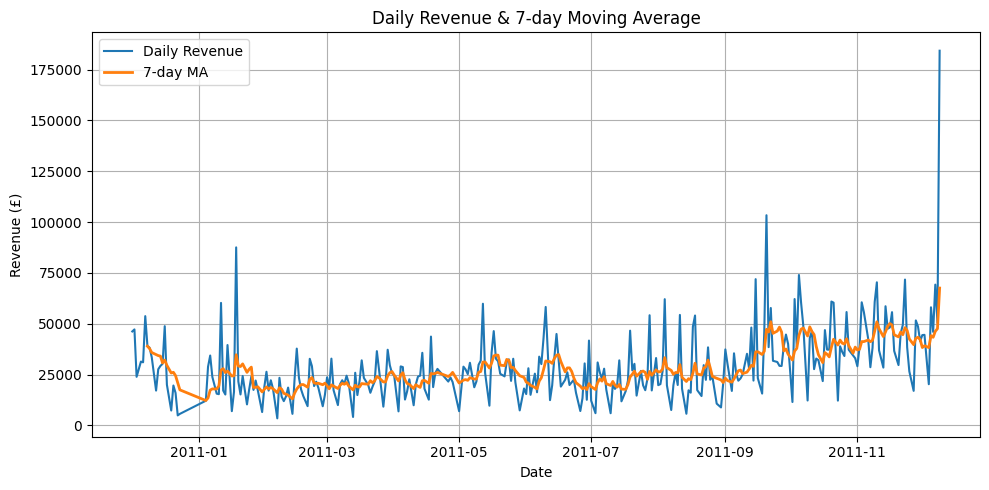

In [13]:
# ---- 4.2 Tren Harian + Moving Average ----
daily_rev = sales_df.groupby('InvoiceDateOnly')['TotalPrice'].sum().sort_index()
ma7 = daily_rev.rolling(7).mean()
plt.figure()
plt.plot(daily_rev.index, daily_rev.values, label='Daily Revenue')
plt.plot(daily_rev.index, ma7.values, label='7-day MA', linewidth=2)
plt.legend()
plt.title("Daily Revenue & 7-day Moving Average")
plt.xlabel("Date"); plt.ylabel("Revenue (£)")
plt.tight_layout(); plt.show()

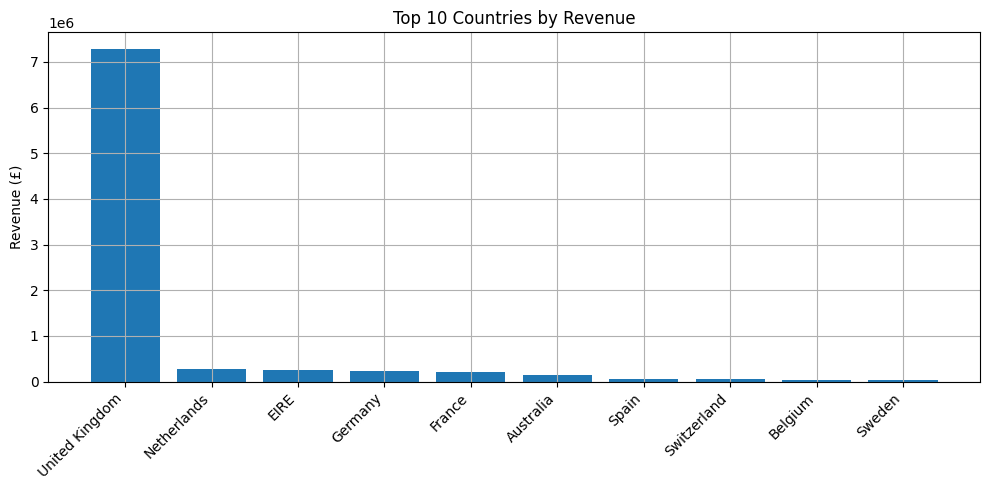

In [14]:
# ---- 4.3 Top Countries by Revenue ----
country_rev = sales_df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)
plt.figure()
plt.bar(country_rev.index, country_rev.values)
plt.title("Top 10 Countries by Revenue")
plt.ylabel("Revenue (£)"); plt.xticks(rotation=45, ha='right')
plt.tight_layout(); plt.show()

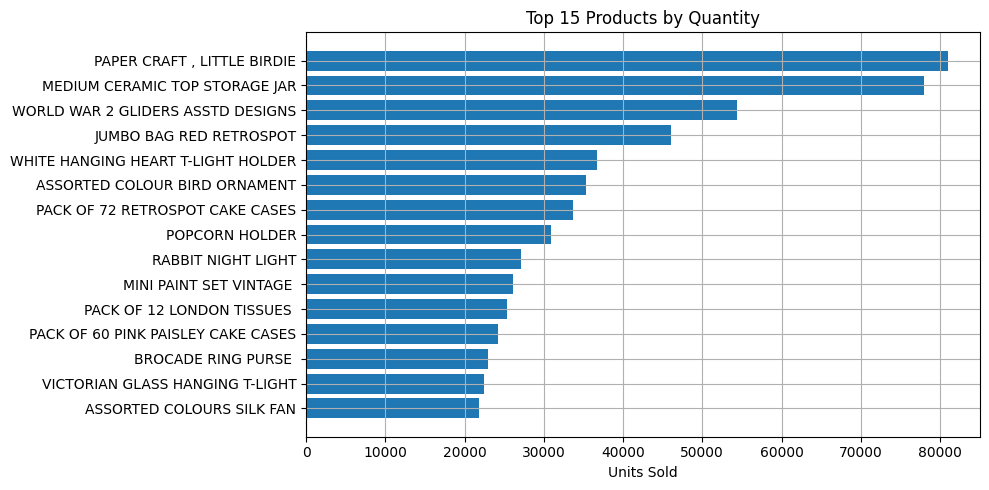

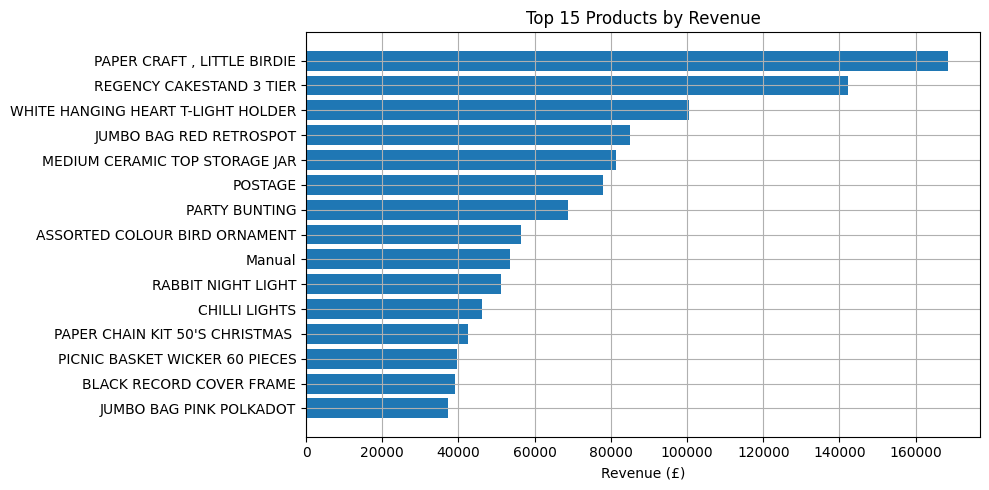

In [15]:
# ---- 4.4 Top Products by Quantity & Revenue ----
desc_qty = sales_df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(15)
plt.figure()
plt.barh(list(desc_qty.index[::-1]), list(desc_qty.values[::-1]))
plt.title("Top 15 Products by Quantity")
plt.xlabel("Units Sold"); plt.tight_layout(); plt.show()

desc_rev = sales_df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(15)
plt.figure()
plt.barh(list(desc_rev.index[::-1]), list(desc_rev.values[::-1]))
plt.title("Top 15 Products by Revenue")
plt.xlabel("Revenue (£)"); plt.tight_layout(); plt.show()

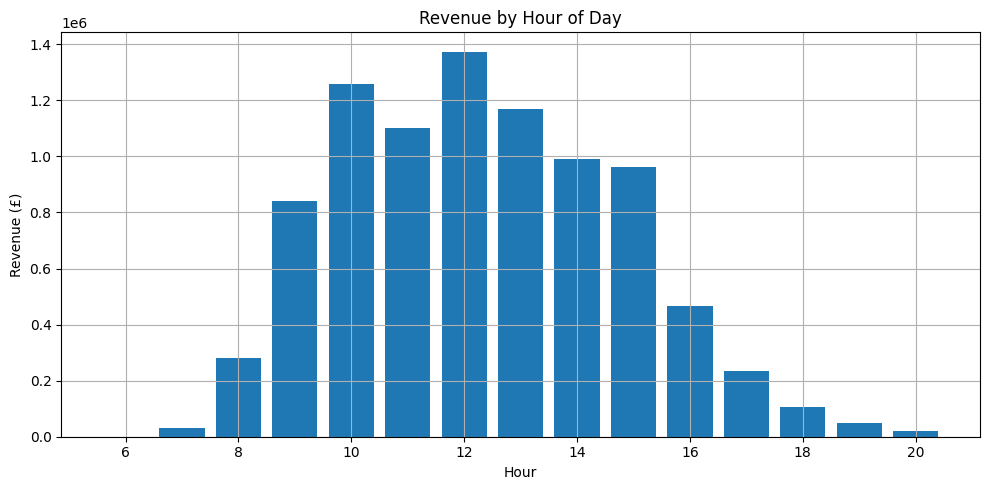

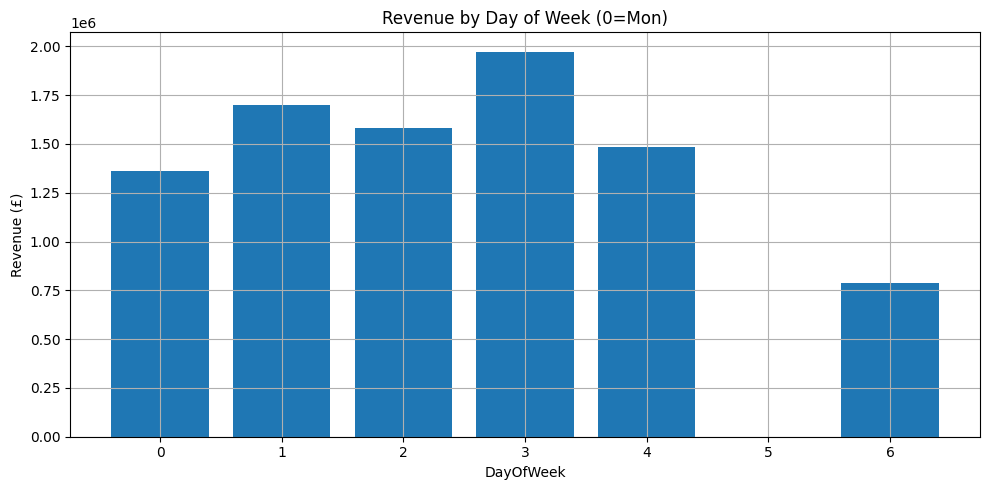

In [16]:
# ---- 4.5 Distribusi Jam & Hari (pola belanja) ----
hour_rev = sales_df.groupby('Hour')['TotalPrice'].sum()
plt.figure()
plt.bar(hour_rev.index, hour_rev.values)
plt.title("Revenue by Hour of Day")
plt.xlabel("Hour"); plt.ylabel("Revenue (£)")
plt.tight_layout(); plt.show()

dow_rev = sales_df.groupby('DayOfWeek')['TotalPrice'].sum()
plt.figure()
plt.bar(dow_rev.index, dow_rev.values)
plt.title("Revenue by Day of Week (0=Mon)")
plt.xlabel("DayOfWeek"); plt.ylabel("Revenue (£)")
plt.tight_layout(); plt.show()

Average Order Value (AOV): £479.53
Avg Items per Order: 277.99


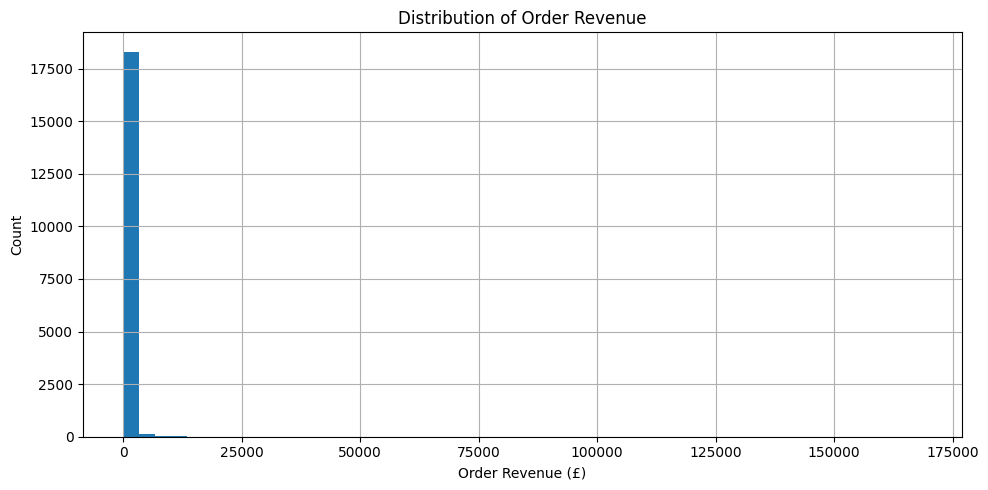

In [17]:
# ---- 4.6 Basket Metrics ----
order_rev = sales_df.groupby('InvoiceNo')['TotalPrice'].sum()
order_items = sales_df.groupby('InvoiceNo')['Quantity'].sum()
AOV = order_rev.mean()
items_per_order = order_items.mean()
print(f"Average Order Value (AOV): £{AOV:,.2f}")
print(f"Avg Items per Order: {items_per_order:,.2f}")

plt.figure()
plt.hist(order_rev.values, bins=50)
plt.title("Distribution of Order Revenue")
plt.xlabel("Order Revenue (£)"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

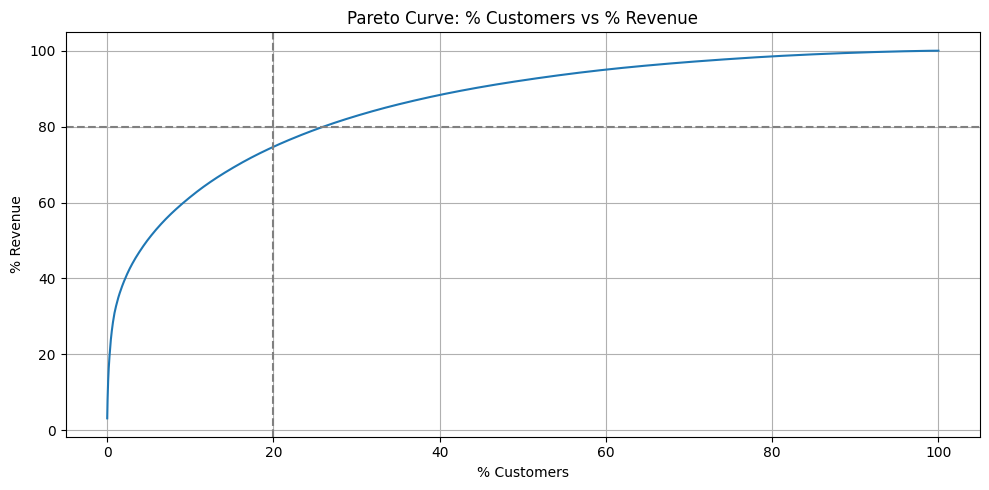

Top 20% customers contribute ≈ 74.7% of revenue


In [18]:
# ---- 4.7 Pareto (80/20) by Customer ----
cust_rev = sales_df.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False)
cum_rev = cust_rev.cumsum() / cust_rev.sum()
x = np.arange(1, len(cust_rev)+1) / len(cust_rev)  # cumulative customers
plt.figure()
plt.plot(x*100, cum_rev.values*100)
plt.axvline(20, color='gray', linestyle='--')
plt.axhline(80, color='gray', linestyle='--')
plt.title("Pareto Curve: % Customers vs % Revenue")
plt.xlabel("% Customers"); plt.ylabel("% Revenue")
plt.tight_layout(); plt.show()

pareto_20pct_revenue_share = cum_rev.iloc[int(0.2*len(cum_rev))-1]
print(f"Top 20% customers contribute ≈ {pareto_20pct_revenue_share*100:.1f}% of revenue")

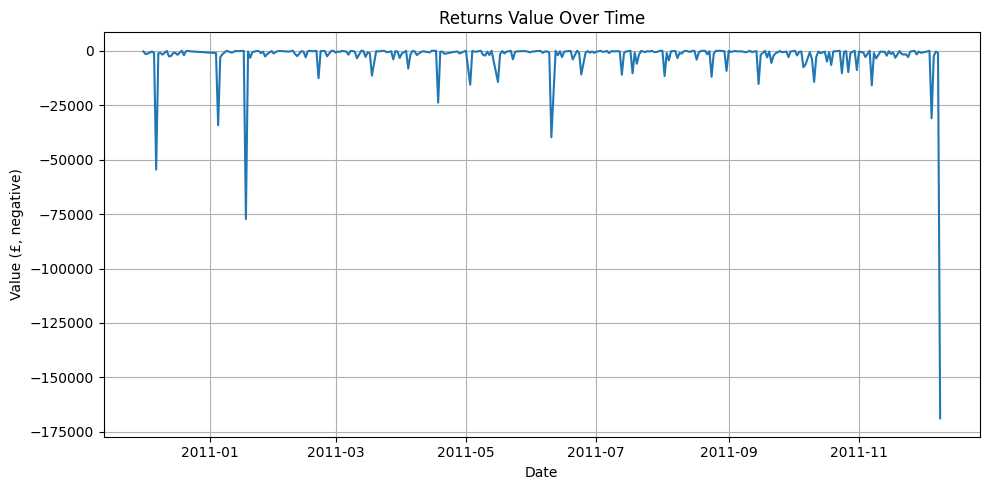

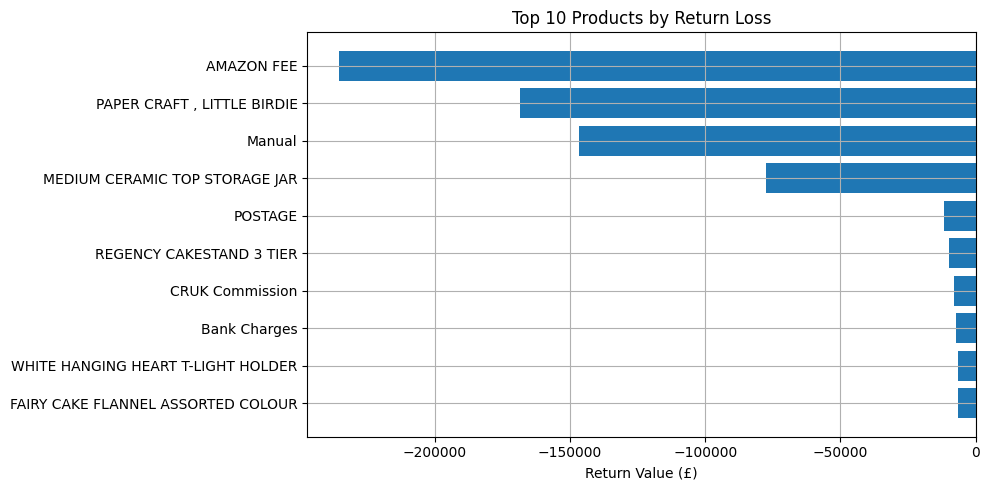

Total returns value: £-896,812.49


In [19]:
# ========== Step 5. Returns Analysis ==========
if len(returns_df) > 0:
    returns_df['InvoiceDate'] = pd.to_datetime(returns_df['InvoiceDate'])
    returns_df['ReturnValue'] = returns_df['Quantity'] * returns_df['UnitPrice']  # negative
    ret_by_day = returns_df.groupby(returns_df['InvoiceDate'].dt.date)['ReturnValue'].sum()

    plt.figure()
    plt.plot(list(ret_by_day.index), list(ret_by_day.values))
    plt.title("Returns Value Over Time")
    plt.xlabel("Date"); plt.ylabel("Value (£, negative)")
    plt.tight_layout(); plt.show()

    top_return_products = returns_df.groupby('Description')['ReturnValue'].sum().sort_values().head(10)  # most negative
    plt.figure()
    plt.barh(list(top_return_products.index[::-1]), list(top_return_products.values[::-1]))
    plt.title("Top 10 Products by Return Loss")
    plt.xlabel("Return Value (£)"); plt.tight_layout(); plt.show()

    total_returns = returns_df['ReturnValue'].sum()
    print(f"Total returns value: £{total_returns:,.2f}")

In [20]:
# ========== Step 6. RFM Segmentation ==========
# 6.1 Aggregate
snapshot_date = sales_df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = sales_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalPrice': 'sum'                                        # Monetary
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'}).reset_index()

In [21]:
# 6.2 Scores (quintiles)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])  # recency rendah = lebih bagus
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score']   = rfm[['R_Score','F_Score','M_Score']].astype(int).sum(axis=1)

In [22]:
# 6.3 Simple segment mapping
def segment_map(row):
    r,f,m = int(row['R_Score']), int(row['F_Score']), int(row['M_Score'])
    if r>=4 and f>=4 and m>=4:
        return 'Champions'
    if r>=4 and f>=3:
        return 'Loyal'
    if r<=2 and f<=2 and m<=2:
        return 'At Risk'
    if r>=3 and f<=2:
        return 'New Customers'
    return 'Regular'
rfm['Segment'] = rfm.apply(segment_map, axis=1)

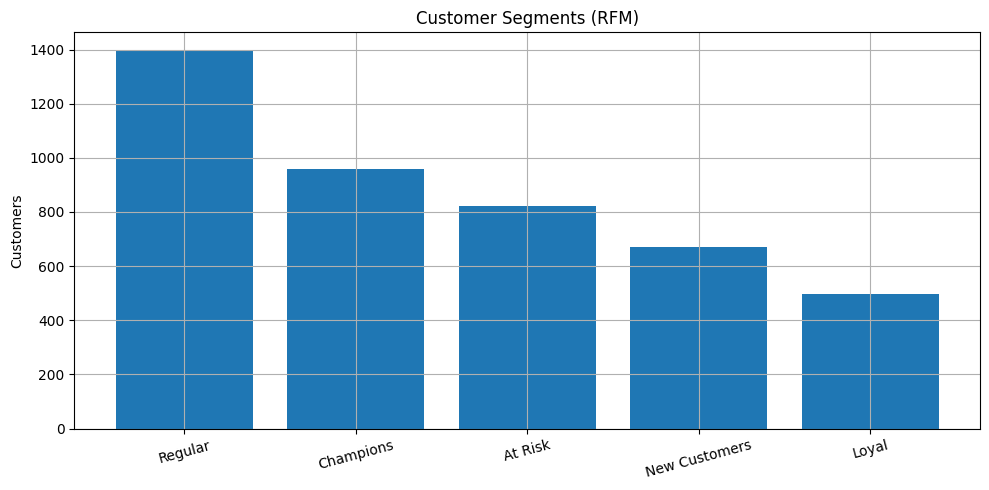

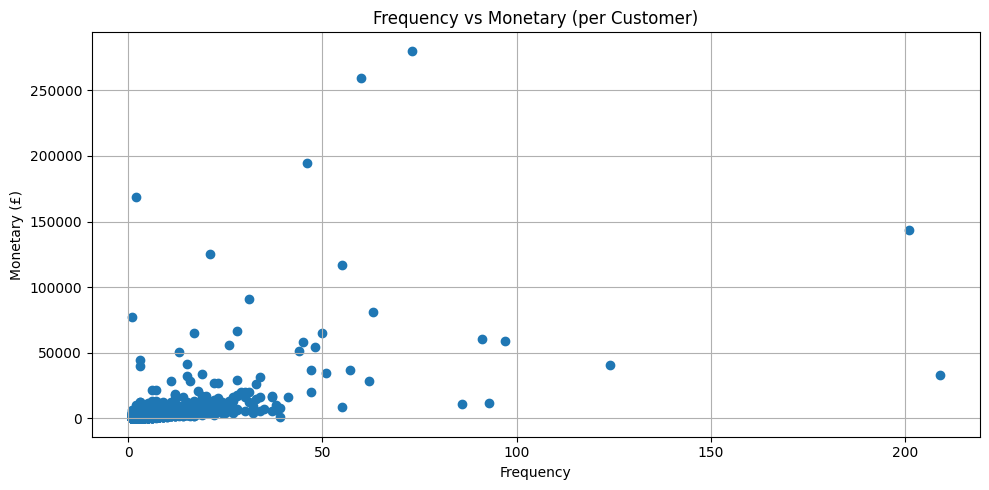

In [23]:
# 6.4 Visuals
seg_counts = rfm['Segment'].value_counts()
plt.figure()
plt.bar(seg_counts.index, seg_counts.values)
plt.title("Customer Segments (RFM)")
plt.ylabel("Customers"); plt.xticks(rotation=15)
plt.tight_layout(); plt.show()

plt.figure()
plt.scatter(rfm['Frequency'], rfm['Monetary'])
plt.title("Frequency vs Monetary (per Customer)")
plt.xlabel("Frequency"); plt.ylabel("Monetary (£)")
plt.tight_layout(); plt.show()

In [25]:
# ========== Step 7. Cohort Analysis (Monthly Retention) ==========
tmp = sales_df[['CustomerID','InvoiceDate']].copy()
tmp['OrderMonth'] = tmp['InvoiceDate'].values.astype('datetime64[M]')
# Cohort: first month a customer ordered
cohort = tmp.groupby('CustomerID')['OrderMonth'].min().rename('CohortMonth')
tmp = tmp.join(cohort, on='CustomerID')
# Cohort index (months since first order)
def month_diff(d1, d2):
    return (d2.year - d1.year) * 12 + (d2.month - d1.month)
tmp['CohortIndex'] = tmp.apply(lambda r: month_diff(r['CohortMonth'], r['OrderMonth']) + 1, axis=1)

cohort_pivot = (tmp.groupby(['CohortMonth','CohortIndex'])['CustomerID']
                  .nunique().reset_index()
                  .pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID'))

cohort_size = cohort_pivot.iloc[:,0]
retention = cohort_pivot.divide(cohort_size, axis=0).round(3)

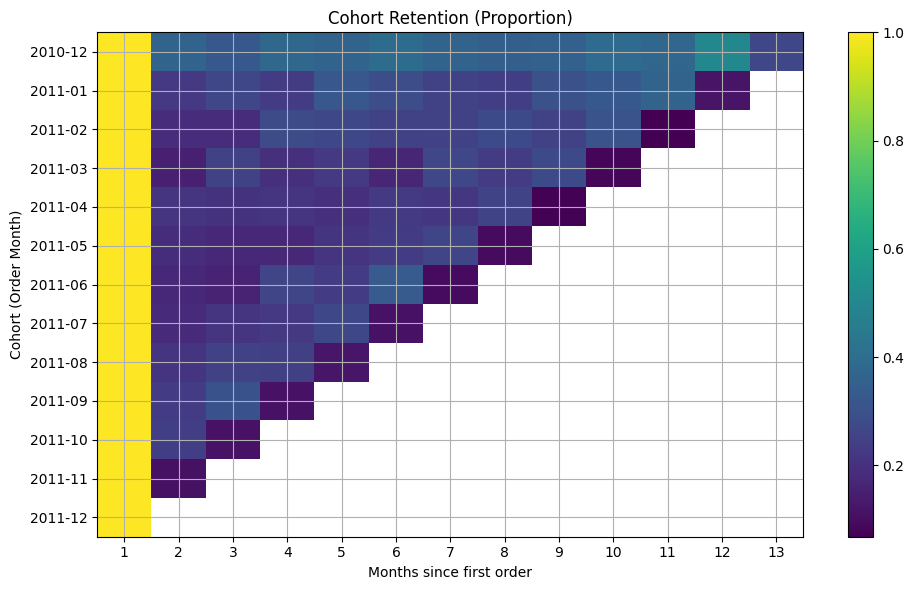

In [ ]:
# Heatmap (matplotlib imshow)
plt.figure(figsize=(10,6))
plt.imshow(retention, aspect='auto')
plt.title("Cohort Retention (Proportion)")
plt.ylabel("Cohort (Order Month)"); plt.xlabel("Months since first order")
plt.colorbar()
plt.xticks(ticks=np.arange(retention.shape[1]), labels=[i+1 for i in range(retention.shape[1])])
plt.yticks(ticks=np.arange(len(retention.index)), labels=[str(i)[:7] for i in retention.index])
plt.tight_layout(); plt.show()

In [ ]:
# ========== Step 8. Auto-Summary (AI-like) ==========
# (Ringkasan berbasis perhitungan agar bisa langsung masuk README/slide)
def bullet(s):
    return "- " + s

summary_lines = []

In [ ]:
# Peak months
peak_months = monthly_rev.sort_values(ascending=False).head(3)
summary_lines.append(bullet(f"Pendapatan tertinggi di bulan: {', '.join(list(peak_months.index))}."))

In [ ]:
# Countries
top_country = country_rev.index[0]
summary_lines.append(bullet(f"Negara penyumbang revenue terbesar: {top_country}."))

In [ ]:
# Pareto
summary_lines.append(bullet(f"Top 20% pelanggan menyumbang sekitar {pareto_20pct_revenue_share*100:.1f}% dari revenue (Pareto)."))

In [ ]:
# Basket
summary_lines.append(bullet(f"Average Order Value (AOV): £{AOV:,.2f}; rata-rata item per order: {items_per_order:.2f}."))

In [ ]:
# Returns
if len(returns_df) > 0:
    summary_lines.append(bullet(f"Total nilai retur: £{total_returns:,.2f} (negatif)."))

In [ ]:
# RFM
champions_n = (rfm['Segment'] == 'Champions').sum()
loyal_n     = (rfm['Segment'] == 'Loyal').sum()
atrisk_n    = (rfm['Segment'] == 'At Risk').sum()
summary_lines.append(bullet(f"Segmen pelanggan: Champions={champions_n}, Loyal={loyal_n}, At Risk={atrisk_n}."))

In [ ]:
print("\n=== AUTO SUMMARY: INSIGHT & FINDINGS ===")
print("\n".join(summary_lines))


=== AUTO SUMMARY: INSIGHT & FINDINGS ===
- Pendapatan tertinggi di bulan: 2011-11, 2011-10, 2011-09.
- Negara penyumbang revenue terbesar: United Kingdom.
- Top 20% pelanggan menyumbang sekitar 74.7% dari revenue (Pareto).
- Average Order Value (AOV): £479.53; rata-rata item per order: 277.99.
- Total nilai retur: £-896,812.49 (negatif).
- Segmen pelanggan: Champions=957, Loyal=496, At Risk=821.


In [ ]:
# Recommendations (rule-based)
reco = []
reco.append(bullet("Fokus kampanye & stok pada bulan puncak (peak months) dan jelang holiday season."))
reco.append(bullet("Bangun loyalty program & eksklusif promo untuk top 20% pelanggan (VIP/Champions)."))
reco.append(bullet("Optimalkan AOV dengan bundling produk dan cross-sell pada kategori terlaris."))
if len(returns_df) > 0:
    reco.append(bullet("Kurangi retur pada produk dengan return-loss tertinggi (perbaiki deskripsi/quality control)."))
reco.append(bullet("Aktifkan kampanye berbasis jam/hari dengan revenue tertinggi (dayparting)."))

print("\n=== AUTO SUMMARY: RECOMMENDATIONS ===")
print("\n".join(reco))


=== AUTO SUMMARY: RECOMMENDATIONS ===
- Fokus kampanye & stok pada bulan puncak (peak months) dan jelang holiday season.
- Bangun loyalty program & eksklusif promo untuk top 20% pelanggan (VIP/Champions).
- Optimalkan AOV dengan bundling produk dan cross-sell pada kategori terlaris.
- Kurangi retur pada produk dengan return-loss tertinggi (perbaiki deskripsi/quality control).
- Aktifkan kampanye berbasis jam/hari dengan revenue tertinggi (dayparting).


In [ ]:
# ========== Step 9. Save Artifacts (untuk repo GitHub) ==========
# Clean data used
sales_df.to_csv('/content/clean_sales.csv', index=False)
daily_rev.to_csv('/content/daily_revenue.csv')
monthly_rev.to_csv('/content/monthly_revenue.csv')

print("\nArtifacts saved:")
print(" - /content/clean_sales.csv")
print(" - /content/rfm_segments.csv")
print(" - /content/daily_revenue.csv")
print(" - /content/monthly_revenue.csv")

print("\nSelesai Silahkan download file di panel kiri Colab dan push ke GitHub.")


Artifacts saved:
 - /content/clean_sales.csv
 - /content/rfm_segments.csv
 - /content/daily_revenue.csv
 - /content/monthly_revenue.csv

Selesai Silahkan download file di panel kiri Colab dan push ke GitHub.


In [ ]:
import requests
import json

# Hasil insight (misal hasil ringkasan clustering dari notebook kamu)
insight_text = """
We segmented UK e-commerce customers using RFM and KMeans clustering:
- Cluster 0: Loyal Customers (High Frequency, High Monetary, Recent purchases)
- Cluster 1: At-Risk Customers (Medium Frequency, Low Recency)
- Cluster 2: Lost Customers (Low Frequency, Old Recency, Low Monetary)
- Cluster 3: Potential Customers (New buyers, Medium Monetary, High Recency)
Please provide marketing strategies and actionable recommendations for each segment.
"""

# Endpoint LM Studio (Granite Model via OpenAI API style)
url = "http://localhost:1234/v1/chat/completions"

headers = {
    "Content-Type": "application/json"
}

payload = {
    "model": "granite-7b-instruct",   # sesuaikan dengan model yang kamu load di LM Studio
    "messages": [
        {"role": "system", "content": "You are an expert data analyst helping in customer segmentation."},
        {"role": "user", "content": insight_text}
    ],
    "temperature": 0.7,
    "max_tokens": 500
}

response = requests.post(url, headers=headers, data=json.dumps(payload))
result = response.json()

print("AI Recommendation from IBM Granite Models:")
print(result["choices"][0]["message"]["content"])